In [1]:
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import numpy as np

In [4]:
from sklearn.tree import DecisionTreeRegressor

import eli5

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error

/home/anatoli/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/anatoli/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
import matplotlib.pyplot as plt

In [6]:
import eli5

from sklearn.linear_model import Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer

In [7]:
listings_df = pd.read_csv("/home/anatoli/Документы/airbnb/listings.csv")

In [8]:
columns = ["neighbourhood_cleansed", "room_type", "property_type", "accommodates", "bathrooms_text", "bedrooms", "beds", "amenities", "price", "minimum_nights"]

In [9]:
places_df = listings_df[columns].copy()

In [10]:
# places_df = places_df[places_df["review_scores_rating"] > 90].copy()

In [11]:
places_df["price_value"] = places_df["price"].apply(lambda x: float(x[1:].replace(",", "")))

In [12]:
places_df["shared_bath"] = places_df["bathrooms_text"].str.lower().str.contains("shared")

In [13]:
places_df["shared_bath"].value_counts()

False    56396
True     19957
Name: shared_bath, dtype: int64

In [14]:
half_baths = places_df["bathrooms_text"].str.lower().str.contains("half-bath")

In [15]:
places_df["baths_number_text"] = places_df["bathrooms_text"].apply(lambda x: str(x).split(" ")[0])

In [16]:
places_df.loc[half_baths.fillna(False), "baths_number_text"] = "0.5"

In [17]:
places_df["baths_number"] = places_df["baths_number_text"].astype(float)

In [18]:
places_df["baths_number"].value_counts()

1.0     52338
2.0     10254
1.5      8741
2.5      2206
3.0      1263
3.5       471
0.0       309
4.0       250
0.5       247
4.5       103
5.0        55
6.0        40
5.5        21
10.0       19
6.5         8
8.0         8
7.0         8
9.0         2
8.5         2
7.5         2
35.0        1
11.0        1
17.0        1
11.5        1
10.5        1
12.0        1
Name: baths_number, dtype: int64

In [19]:
places_df["beds"].value_counts()

1.0     41696
2.0     17707
3.0      7114
4.0      3271
0.0      2850
5.0      1365
6.0       680
7.0       274
8.0       145
9.0        67
10.0       65
11.0       19
12.0       17
15.0        9
14.0        8
16.0        7
13.0        5
18.0        4
20.0        2
17.0        2
24.0        2
21.0        1
19.0        1
28.0        1
22.0        1
50.0        1
27.0        1
Name: beds, dtype: int64

In [20]:
places_df["beds_per_accommodate"] = places_df["beds"] / places_df["accommodates"]

In [21]:
places_df["bathrooms_per_accommodate"] = places_df["baths_number"] / places_df["accommodates"]

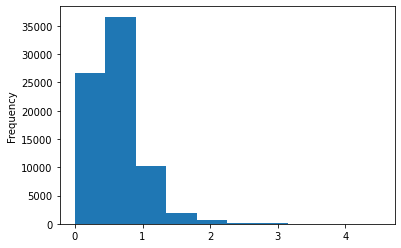

In [22]:
places_df[places_df["bathrooms_per_accommodate"] < 5]["bathrooms_per_accommodate"].plot(kind="hist")

In [23]:
places_df["bedrooms_per_accommodate"] = places_df["bedrooms"] / places_df["accommodates"]

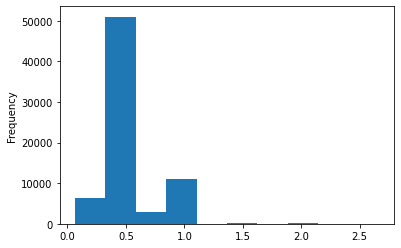

In [24]:
places_df[places_df["bedrooms_per_accommodate"] < 3]["bedrooms_per_accommodate"].plot(kind="hist")

In [25]:
places_df["beds_per_bedroom"] = places_df["beds"] / places_df["bedrooms"]

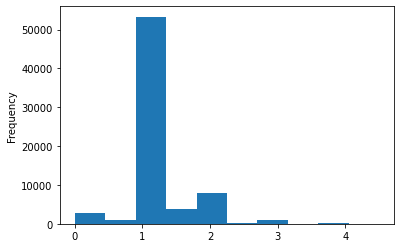

In [26]:
places_df[places_df["beds_per_bedroom"] < 5]["beds_per_bedroom"].plot(kind="hist")

In [27]:
places_df["price_per_accommodate"] = places_df["price_value"] / places_df["accommodates"]

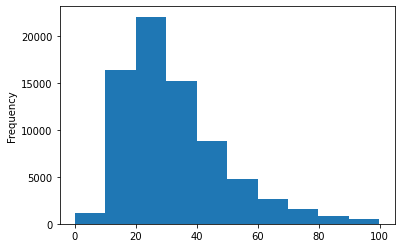

In [28]:
places_df[places_df["price_per_accommodate"] < 100]["price_per_accommodate"].plot(kind="hist")

In [29]:
common_places = places_df["property_type"].value_counts().iloc[0:30].index
places_df["property_type_fixed"] = places_df["property_type"]
places_df.loc[~places_df["property_type"].isin(common_places), "property_type_fixed"] = "Exotic"

In [30]:
property_types = [
    "boutique hotel", "villa", "condominium", "hotel", "bed and breakfast", "serviced apartment",
    "boat", "exotic", "loft", "cottage", "home/apt", "guest suite", "house", "apartment",
    "hostel", "houseboat", "earth house", "tiny house", "townhouse", "aparthotel", "bungalow",
    "cabin", "place", "guesthouse", "room", "chalet", "camper"
]

In [31]:
def detect_property_type(type):
    matched_types = [p for p in property_types if p in type.lower()]
    if len(matched_types) == 0:
        print(type)
        return "unknown"
    return max(matched_types, key=len)

In [32]:
places_df["property_type_detected"] = places_df["property_type_fixed"].apply(detect_property_type)

# Price insights

Цену определяет тип комнаты и район

In [33]:
avg_prices_df = places_df.groupby(["neighbourhood_cleansed", "room_type"])[["price_value", "price_per_accommodate"]].mean().reset_index()

In [34]:
places_df = places_df.merge(avg_prices_df, on=["neighbourhood_cleansed", "room_type"], suffixes=("", "_average"))

In [35]:
places_df["price_diff"] = (places_df["price_value"] - places_df["price_value_average"]) # / places_df["price_value_average"]

In [36]:
places_df["room_type"].value_counts()

Entire home/apt    41633
Private room       33734
Shared room          608
Hotel room           559
Name: room_type, dtype: int64

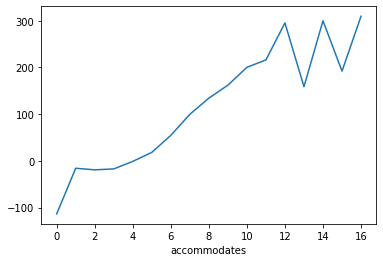

In [37]:
places_df.groupby(["accommodates"])["price_diff"].mean().plot()

In [38]:
places_df["price_per_accommodate_diff"] = (places_df["price_per_accommodate"] - places_df["price_per_accommodate_average"])

In [39]:
places_df["price_per_accommodate_percentage_diff"] = (places_df["price_per_accommodate"] - places_df["price_per_accommodate_average"]) / places_df["price_per_accommodate_average"]

In [40]:
places_df["outlier"] = False
places_df.loc[np.abs(places_df["price_per_accommodate_percentage_diff"]) > 2, "outlier"] = True

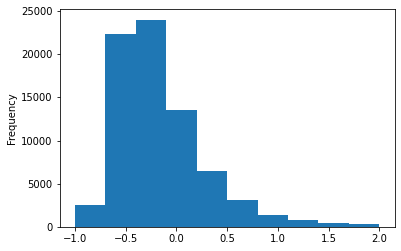

In [41]:
places_df[~places_df["outlier"]]["price_per_accommodate_percentage_diff"].plot(kind="hist")

Кол-во жильцов

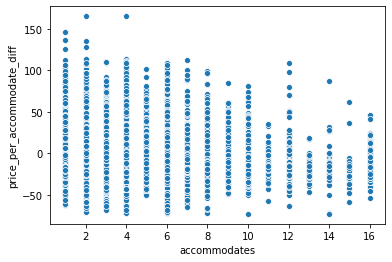

In [42]:
sns.scatterplot(
    data=places_df[(~places_df["outlier"])],
    x="accommodates",
    y="price_per_accommodate_diff"
)

In [54]:
places_df["shared_bath_text"] = places_df["shared_bath"].apply({True: "Yes", False: "No"}.get)

Text(0.5, 1.0, 'The bath is shared')

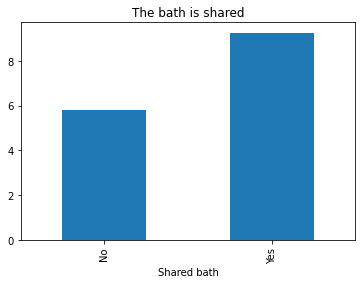

In [59]:
(-places_df[~places_df["outlier"]].groupby("shared_bath_text")["price_per_accommodate_diff"].mean()).plot(kind="bar")
plt.xlabel("Shared bath")
plt.title("The bath is shared - a")

Text(0.5, 1.0, 'Price per accommodate in $ - average difference')

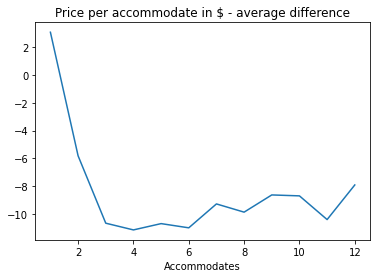

In [47]:
places_df[~places_df["outlier"] & (places_df["accommodates"] < 13)].groupby("accommodates")["price_per_accommodate_diff"].mean().plot()
plt.xlabel("Accommodates")
plt.title("Price per accommodate in $ - average difference")

В зависимости от количества заселяемых человек, цена на человека резко падает, а затем остается почти на том же уровне

In [44]:
# common_places = places_df["property_type"].value_counts().iloc[0:30].index
# places_df["property_type_fixed"] = places_df["property_type"]
# places_df.loc[~places_df["property_type"].isin(common_places), "property_type_fixed"] = "Exotic"

In [45]:
# places_df.groupby(["property_type_fixed"])["price_per_accommodate_diff"].agg(["mean", "std", "count"]).sort_values("mean", ascending=True).dropna().iloc[0:20]

Важно место, где именно находится комната

In [46]:
# places_df.groupby(["property_type_fixed"])["price_per_accommodate_diff"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False).dropna().iloc[0:20]

In [47]:
# places_df[(places_df["bedrooms_per_accommodate"] <= 1) & (places_df["room_type"] == "Private room")]["price_value"]

In [48]:
def get_class(x):
    if np.isnan(x):
        return np.nan
    if x < 1:
        return round(x, 1)
    return 1

In [49]:
get_class(1), get_class(0.11), get_class(11.1)

(1, 0.1, 1)

In [50]:
places_df["bedrooms_per_accommodate_class"] = places_df["bedrooms_per_accommodate"].apply(get_class)
places_df["beds_per_accommodate_class"] = places_df["beds_per_accommodate"].apply(get_class)
places_df["bathrooms_per_accommodate_class"] = places_df["bathrooms_per_accommodate"].apply(get_class)

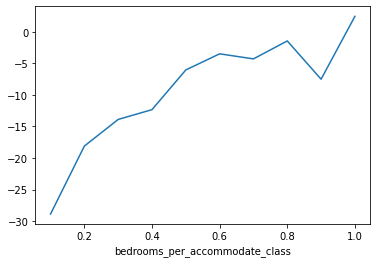

In [51]:
places_df[ (~places_df["outlier"])].groupby("bedrooms_per_accommodate_class")["price_per_accommodate_diff"].mean().plot()

/home/anatoli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


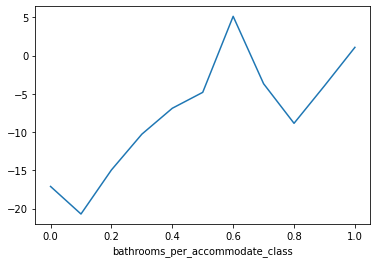

In [52]:
places_df[places_df["bathrooms_per_accommodate"] > 0][(~places_df["outlier"])].groupby("bathrooms_per_accommodate_class")["price_per_accommodate_diff"].mean().plot()

/home/anatoli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


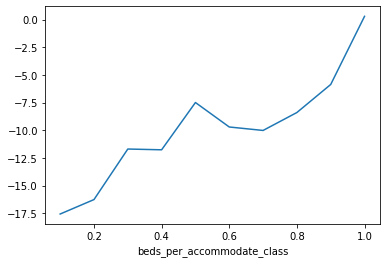

In [53]:
places_df[places_df["beds_per_accommodate"] > 0][(~places_df["outlier"])].groupby("beds_per_accommodate_class")["price_per_accommodate_diff"].mean().plot()

In [54]:
places_df[~places_df["outlier"]].sort_values("price_per_accommodate_diff", ascending=False).iloc[0:30]

,neighbourhood_cleansed,room_type,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,...,property_type_detected,price_value_average,price_per_accommodate_average,price_diff,price_per_accommodate_diff,price_per_accommodate_percentage_diff,outlier,bedrooms_per_accommodate_class,beds_per_accommodate_class,bathrooms_per_accommodate_class
74067,City of London,Entire home/apt,Entire apartment,4,1 bath,2.0,2.0,"[""Oven"", ""Shampoo"", ""Dedicated workspace"", ""Re...","$1,000.00",90,...,apartment,280.979275,84.705672,719.020725,165.294328,1.951396,False,0.5,0.5,0.2
74044,City of London,Entire home/apt,Entire apartment,2,1 bath,1.0,1.0,"[""Long term stays allowed"", ""Dryer"", ""Kitchen""...",$500.00,1,...,apartment,280.979275,84.705672,219.020725,165.294328,1.951396,False,0.5,0.5,0.5
75388,Brent,Shared room,Shared room in hostel,1,0 shared baths,1.0,1.0,"[""Shampoo"", ""Long term stays allowed"", ""Hanger...",$220.00,1,...,hostel,80.000000,73.864286,140.000000,146.135714,1.978435,False,1.0,1.0,0.0
75374,Brent,Shared room,Shared room in house,1,1 shared bath,1.0,1.0,"[""Long term stays allowed""]",$211.00,1,...,house,80.000000,73.864286,131.000000,137.135714,1.856590,False,1.0,1.0,1.0
75381,Brent,Shared room,Shared room in hostel,1,0 shared baths,1.0,1.0,"[""Shampoo"", ""Long term stays allowed"", ""Dryer""...",$210.00,1,...,hostel,80.000000,73.864286,130.000000,136.135714,1.843052,False,1.0,1.0,0.0
74099,City of London,Entire home/apt,Entire house,2,1 bath,NaN,1.0,"[""Shampoo"", ""Pool"", ""Hangers"", ""Essentials"", ""...",$440.00,1,...,house,280.979275,84.705672,159.020725,135.294328,1.597229,False,NaN,0.5,0.5
76204,Westminster,Hotel room,Room in hotel,2,1 bath,1.0,1.0,"[""Shampoo"", ""Long term stays allowed"", ""Hanger...",$383.00,1,...,hotel,166.633333,63.844034,216.366667,127.655966,1.999497,False,0.5,0.5,0.5
75382,Brent,Shared room,Shared room in hostel,1,0 shared baths,1.0,1.0,"[""Shampoo"", ""Long term stays allowed"", ""Dryer""...",$200.00,1,...,hostel,80.000000,73.864286,120.000000,126.135714,1.707669,False,1.0,1.0,0.0
6403,Westminster,Entire home/apt,Entire apartment,2,1 bath,1.0,1.0,"[""Cable TV"", ""Dishwasher"", ""Iron"", ""Coffee mak...",$345.00,1,...,apartment,213.202377,58.285227,131.797623,114.214773,1.959584,False,0.5,0.5,0.5
11268,Westminster,Entire home/apt,Entire apartment,2,1 bath,1.0,1.0,"[""Oven"", ""Shampoo"", ""Refrigerator"", ""Hangers"",...",$345.00,2,...,apartment,213.202377,58.285227,131.797623,114.214773,1.959584,False,0.5,0.5,0.5


In [243]:
# places_df[(places_df["bedrooms_per_accommodate"] >= 1) & (~places_df["outlier"])].groupby("bedrooms_per_accommodate_class")["price_per_accommodate"].mean().plot()

Если количество кроватей больше или меньше 0.5 на спальню - цена на человека резко снижается. В противном случае на цену не влияет

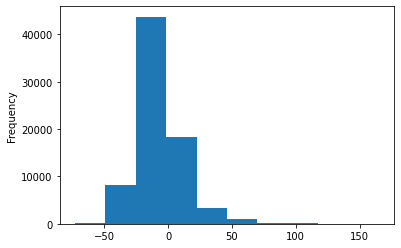

In [303]:
places_df[~places_df["outlier"]]["price_per_accommodate_diff"].plot(kind="hist")

В датасете есть выбросы. Цена, которая отличается от среднего более чем в 2 раза

# Feature engineering

- Жителей 1, 2, 3, >3
- Количество спален на человека <1, =1, >1
- Количество ванн на человека <1, =1, >1
- Количество кроватей на спальню  <.5, =.5, >.5
- Удалить разницу в ценах > x2

In [52]:
dataset_df = places_df[places_df["price_per_accommodate_diff"] < 2][[
    "room_type", "accommodates", "bedrooms_per_accommodate", 
    "beds_per_accommodate", "bathrooms_per_accommodate", 
    "shared_bath", "price_per_accommodate_diff"
]].copy()

In [53]:
# from sklearn.preprocessing import LabelEncoder

In [54]:
# dataset_df = pd.get_dummies(dataset_df, columns=["property_type_detected"])

In [55]:
dataset_df = pd.get_dummies(dataset_df, columns=["room_type"])

In [56]:
for i in range(1, 4):
    dataset_df[f"accommodates={i}"] = dataset_df["accommodates"] == i

In [57]:
dataset_df["accommodates>3"] = dataset_df["accommodates"] > 3

In [58]:
dataset_df["bedrooms<1"] = dataset_df["bedrooms_per_accommodate"] < 1
dataset_df["bedrooms=1"] = dataset_df["bedrooms_per_accommodate"] == 1
dataset_df["bedrooms>1"] = dataset_df["bedrooms_per_accommodate"] > 1

In [59]:
dataset_df["bathrooms<1"] = dataset_df["bathrooms_per_accommodate"] < 1
dataset_df["bathrooms=1"] = dataset_df["bathrooms_per_accommodate"] == 1
dataset_df["bathrooms>1"] = dataset_df["bathrooms_per_accommodate"] > 1

In [60]:
dataset_df["beds<.5"] = dataset_df["beds_per_accommodate"] < .5
dataset_df["beds=.5"] = dataset_df["beds_per_accommodate"] == .5
dataset_df["beds~1"] = (dataset_df["beds_per_accommodate"] > .5) & (dataset_df["beds_per_accommodate"] <= 1)
dataset_df["beds>1"] = dataset_df["beds_per_accommodate"] > 1

In [61]:
dataset_df["shared_bath"] = dataset_df["shared_bath"].fillna(False)

In [62]:
dataset_df.drop(columns=["accommodates", "bedrooms_per_accommodate", "beds_per_accommodate", "bathrooms_per_accommodate"], inplace=True)

# First model

In [63]:
# dataset_df["outlier"] = (dataset_df["price_diff"] > dataset_df["price_diff"].std()) \
#     | (dataset_df["price_diff"] < -dataset_df["price_diff"].std())

In [64]:
# dataset_df.loc[dataset_df["price_diff"] == 0, "price_diff"] = np.abs(dataset_df[dataset_df["price_diff"] != 0]["price_diff"]).min()

In [65]:
# dataset_df["outlier"].value_counts()

In [66]:
# dataset_df["price_log"] = np.log(dataset_df["price_per_accommodate"] + 1)

In [67]:
# dataset_df.loc[dataset_df["price_log"].idxmin()]["price_per_accommodate"]

In [68]:
# np.log(dataset_df[~dataset_df["outlier"]]["price_per_accommodate"] + 1).plot(kind="hist")

In [69]:
dataset_df.isnull().sum()

shared_bath                   0
price_per_accommodate_diff    0
room_type_Entire home/apt     0
room_type_Hotel room          0
room_type_Private room        0
room_type_Shared room         0
accommodates=1                0
accommodates=2                0
accommodates=3                0
accommodates>3                0
bedrooms<1                    0
bedrooms=1                    0
bedrooms>1                    0
bathrooms<1                   0
bathrooms=1                   0
bathrooms>1                   0
beds<.5                       0
beds=.5                       0
beds~1                        0
beds>1                        0
dtype: int64

In [70]:
dataset_df = dataset_df.dropna()

# Amenities

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
# def preprocess_word(w):
#     # Replace numbers

In [73]:
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)

In [74]:
# amenities_matrix = vectorizer.fit_transform(dataset_df["amenities"])

In [75]:
# amenities_df = pd.DataFrame(amenities_matrix.todense(), columns=vectorizer.get_feature_names(), index=dataset_df.index)

# Model

In [115]:
# model = RandomForestRegressor()
# model = Ridge()
model = ElasticNet()

In [119]:
# grid = {"max_depth": [3, 4, 5, 6, 8]}
# grid = {"n_estimators": [300]}
# grid = {"alpha": np.linspace(6000, 7000, 50)}
grid = {"alpha": np.logspace(-2, 2, 30)}

In [122]:
X = dataset_df.dropna().drop(columns="price_per_accommodate_diff")

In [123]:
# X = dataset_df[
#     ~dataset_df["outlier"]
# ].dropna()\
# .drop(columns=[
#     "neighbourhood_cleansed", "price_per_accommodate_average", "price_per_accommodate", 
#     "outlier", "price_diff", "price_log"
# ])

In [124]:
# X = X.merge(amenities_df, left_index=True, right_index=True)

In [125]:
y = dataset_df.dropna()["price_per_accommodate_diff"]

In [126]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [154]:
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred[y_true != 0] - y_true[y_true != 0]) / np.maximum(np.abs(y_true[y_true != 0]), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None
    
    return np.average(output_errors, weights=multioutput)

Бэйслайн - средние значения

In [155]:
# Baseline
mean_absolute_percentage_error(test_y, np.zeros(len(test_y)))

(61774    1.0
 48349    1.0
 26584    1.0
 25202    1.0
 14686    1.0
         ... 
 10864    1.0
 6989     1.0
 48313    1.0
 68473    1.0
 2986     1.0
 Name: price_per_accommodate_diff, Length: 22531, dtype: float64,
 1.0)

In [128]:
# mean_absolute_percentage_error(test_y,test_prediction)

In [140]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [141]:
search = GridSearchCV(model, grid, cv=5, scoring=mape_scorer)

In [142]:
search.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89390092e-02, 6.72335754e-02, 9.23670857e-02,
       1.26896100e-01, 1.74332882e-01, 2.39502662e-01, 3.29034456e-01,
       4.52035366e-01, 6.21016942e-01, 8.53167852e-01, 1.17210230e+00,
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02])},
             scoring=make_scorer(mean_absolute_percentage_error))

In [149]:
# tt = search.predict(train_X)

In [150]:
mean_absolute_percentage_error(train_y, tt)

2.108249484397661

In [145]:
search.best_estimator_

ElasticNet(alpha=0.09236708571873861)

In [148]:
search.best_score_

2.1082019973040267

In [147]:
test_prediction = search.predict(test_X)

In [151]:
mean_absolute_percentage_error(test_y, test_prediction)

2.180767917940364

In [100]:
# test_X

1.78519729575021

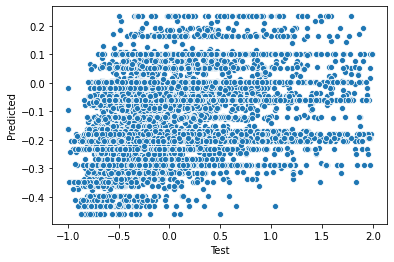

In [101]:
test_indices = [True] * len(test_y)

sns.scatterplot(test_y[test_indices], test_prediction[test_indices])
plt.xlabel("Test")
plt.ylabel("Predicted")
# sns.scatterplot(test_y[test_indices], test_y[test_indices] - test_prediction[test_indices])

mean_absolute_percentage_error(test_y[test_indices], test_prediction[test_indices])
# plt.xlim(-1, 2)
# plt.ylim(-1, 2)

In [102]:
big_prediction = test_prediction > 0.23
big_diff = test_y > 1
difference_index = test_X[big_prediction & big_diff].index

In [103]:
listings_df.loc[difference_index]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
22690,17636666,https://www.airbnb.com/rooms/17636666,20210209201301,2021-02-11,Wonderful Warwick Avenue 2Bed/2Bath With Terrace,This beautiful professionally-managed two doub...,Warwick Avenue is a residential avenue in the ...,https://a0.muscache.com/pictures/ebf440df-590a...,23234040,https://www.airbnb.com/users/show/23234040,...,10.0,10.0,10.0,NaN,f,50,46,4,0,1.00
5523,5047528,https://www.airbnb.com/rooms/5047528,20210209201301,2021-02-12,"Double room, bathroom, Hammersmith",Attractive double room with sole use of large ...,Hammersmith is an attractive part of London wi...,https://a0.muscache.com/pictures/65339908/93c1...,26058133,https://www.airbnb.com/users/show/26058133,...,10.0,9.0,10.0,NaN,f,1,0,1,0,0.50
38288,26268360,https://www.airbnb.com/rooms/26268360,20210209201301,2021-02-13,Salisbury Room in Northfields,This is a beautiful private room with an en-su...,The location is fantastic very close to the So...,https://a0.muscache.com/pictures/5cfc9d2d-ae85...,148508088,https://www.airbnb.com/users/show/148508088,...,10.0,10.0,9.0,NaN,t,2,0,2,0,0.26
48462,33063305,https://www.airbnb.com/rooms/33063305,20210209201301,2021-02-14,Splendid 2 bedroom Apartment in White City,2 Bedroom Apartment close to BBC Television Ce...,This apartment is situated in a centrally loca...,https://a0.muscache.com/pictures/fb306a82-2009...,248824069,https://www.airbnb.com/users/show/248824069,...,10.0,9.0,9.0,NaN,f,3,3,0,0,0.21
2373,1765870,https://www.airbnb.com/rooms/1765870,20210209201301,2021-02-13,Double Room near Excel Exhibition,Hi I have a nice Cozy Double room available ju...,NaN,https://a0.muscache.com/pictures/73336635/5963...,9279225,https://www.airbnb.com/users/show/9279225,...,9.0,9.0,9.0,NaN,f,1,0,1,0,0.87
6451,6041500,https://www.airbnb.com/rooms/6041500,20210209201301,2021-02-12,"Private doble room, great location","Easy transport to anywhere in London, Station:...",We have convenience and fruit shops just next ...,https://a0.muscache.com/pictures/75245358/7180...,31351924,https://www.airbnb.com/users/show/31351924,...,10.0,8.0,9.0,NaN,f,1,0,1,0,0.03
32229,22349534,https://www.airbnb.com/rooms/22349534,20210209201301,2021-02-11,CLEVELAND ONE BED PET FRIENDLY BASEMENT APARTMENT,Beautifully furnished and with all the necessi...,Fitzrovia offers visitors the diversity associ...,https://a0.muscache.com/pictures/835dce08-3f31...,54987,https://www.airbnb.com/users/show/54987,...,10.0,10.0,9.0,NaN,t,27,27,0,0,0.34
75240,47067615,https://www.airbnb.com/rooms/47067615,20210209201301,2021-02-12,Stunning 1 bed Westbourne Grove/Notting Hill,A beautifully presented and well located 1 bed...,NaN,https://a0.muscache.com/pictures/cf03e3ac-d333...,37056489,https://www.airbnb.com/users/show/37056489,...,NaN,NaN,NaN,NaN,t,7,7,0,0,NaN
71287,45301290,https://www.airbnb.com/rooms/45301290,20210209201301,2021-02-12,Ground floor Studio,NaN,NaN,https://a0.muscache.com/pictures/ce0e5271-5f90...,202352034,https://www.airbnb.com/users/show/202352034,...,10.0,10.0,10.0,NaN,f,3,2,1,0,1.37
66438,42656015,https://www.airbnb.com/rooms/42656015,20210209201301,2021-02-12,☼ Modern 2Bed Apt - 15mins to Houses of Parlia...,You'll be staying right in the centre of the c...,"Located in the heart of London, Pimlico’s bric...",https://a0.muscache.com/pictures/063e2abf-2608...,339802053,https://www.airbnb.com/users/show/339802053,...,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN


In [104]:
eli5.explain_weights(search.best_estimator_, feature_names=list(X.columns))

Weight?,Feature
+0.088,accommodates=1
+0.071,bedrooms=1
+0.066,room_type_Entire home/apt
+0.053,bathrooms=1
+0.046,accommodates=2
+0.023,beds~1
+0.008,beds>1
+0.007,bedrooms>1
+0.004,bathrooms>1
+0.004,room_type_Hotel room


In [105]:
# test_source_prices = (test_y * np.exp(test_X["price_average_log"]) + np.exp(test_X["price_average_log"])) * test_X["accommodates"]

# test_predicted_prices = (test_prediction * np.exp(test_X["price_average_log"]) + np.exp(test_X["price_average_log"])) * test_X["accommodates"]


In [106]:
# test_source_prices = (test_y * np.exp(test_X["price_average_log"]) + np.exp(test_X["price_average_log"])) * test_X["accommodates"]

# test_predicted_prices = (test_prediction * np.exp(test_X["price_average_log"]) + np.exp(test_X["price_average_log"])) * test_X["accommodates"]

# sns.scatterplot(test_source_prices, test_predicted_prices)
# plt.xlabel("Test")
# plt.ylabel("Predicted")

In [107]:
# mean_absolute_percentage_error(test_source_prices, test_predicted_prices)

In [ ]:
test_indices = test_X["accommodates"] > 0

sns.scatterplot(test_y[test_indices], test_prediction[test_indices])
plt.xlabel("Test")
plt.ylabel("Predicted")
# sns.scatterplot(test_y[test_indices], test_y[test_indices] - test_prediction[test_indices])

mean_absolute_percentage_error(test_y[test_indices], test_prediction[test_indices])

In [273]:
np.argsort(np.abs(test_y - test_prediction))

30724    10507
70636    10171
37487    20246
3159     17933
66268     3950
         ...  
28692     4592
6463      4426
33527    12671
52052     9872
45144     6515
Name: price_diff, Length: 20848, dtype: int64

In [1413]:
best_prediction_indices = np.argsort(np.abs(test_y.values - test_prediction))[0:100]

In [1414]:
best_df = test_X.iloc[
    best_prediction_indices
].copy()
best_df["actual"] = test_y.iloc[best_prediction_indices]
best_df["predicted"] = test_prediction[best_prediction_indices]

In [1415]:
worst_prediction_indices = np.argsort(-np.abs(test_y.values - test_prediction))[0:100]

In [1416]:
best_df

,shared_bath,property_type_detected_aparthotel,property_type_detected_apartment,property_type_detected_bed and breakfast,property_type_detected_boat,property_type_detected_boutique hotel,property_type_detected_bungalow,property_type_detected_condominium,property_type_detected_exotic,property_type_detected_guest suite,...,bedrooms>1,bathrooms<1,bathrooms=1,bathrooms>1,beds<.5,beds=.5,beds~1,beds>1,actual,predicted
17446,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,False,-0.172387,-0.172391
18237,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,False,-0.172387,-0.172391
7409,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,False,-0.237466,-0.237522
25795,True,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,-0.291538,-0.291482
27427,True,0,0,0,0,0,0,0,0,0,...,False,False,True,False,False,False,True,False,0.017169,0.017238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56442,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,-0.210228,-0.212358
23419,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,-0.210201,-0.212358
28039,False,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,-0.186265,-0.188425
21584,True,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,-0.293650,-0.291482


In [1417]:
worst_df = test_X.iloc[
    worst_prediction_indices
].copy()
worst_df["actual"] = test_y.iloc[worst_prediction_indices]
worst_df["predicted"] = test_prediction[worst_prediction_indices]

In [1418]:
worst_df

,shared_bath,property_type_detected_aparthotel,property_type_detected_apartment,property_type_detected_bed and breakfast,property_type_detected_boat,property_type_detected_boutique hotel,property_type_detected_bungalow,property_type_detected_condominium,property_type_detected_exotic,property_type_detected_guest suite,...,bedrooms>1,bathrooms<1,bathrooms=1,bathrooms>1,beds<.5,beds=.5,beds~1,beds>1,actual,predicted
74683,True,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,1.966991,-0.291482
24477,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,1.951925,-0.260698
27035,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,1.996616,-0.212358
46754,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,False,1.940074,-0.237522
74608,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,1.966991,-0.194926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12890,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,1.743283,-0.015240
47570,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,1.744069,-0.009499
68189,False,0,1,0,0,0,0,0,0,0,...,False,True,False,False,False,False,True,False,1.719427,-0.032455
60617,False,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,1.739383,-0.012451


In [970]:
# test_indices = test_X["accommodates"] == 

# sns.scatterplot(test_y[test_indices], test_prediction[test_indices])

In [971]:
mean_squared_error(test_y[test_X["accommodates"] == 1], test_prediction[test_X["accommodates"] == 1])

0.1926454806460342

In [972]:
mean_squared_error(test_y[test_X["accommodates"] == 2], test_prediction[test_X["accommodates"] == 2])

0.1654019190254556

In [973]:
mean_squared_error(test_y[test_X["accommodates"] == 3], test_prediction[test_X["accommodates"] == 3])

0.178168151611415

In [974]:
test_X

,accommodates,bedrooms_per_accommodate,beds_per_bedroom,shared_bath,bathrooms_per_accommodate,price_average_log,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
55504,3,0.666667,1.5,False,0.500000,4.020201,1,0,0,0
69245,2,0.500000,1.0,False,0.500000,3.508370,1,0,0,0
31577,2,0.500000,1.0,True,0.500000,3.415166,0,0,1,0
37677,3,0.333333,1.0,False,0.333333,3.662993,1,0,0,0
44339,2,0.500000,1.0,True,0.500000,3.381932,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
43420,2,0.500000,1.0,False,0.500000,3.381932,0,0,1,0
59738,2,0.500000,1.0,True,0.500000,3.388601,0,0,1,0
1087,2,0.500000,1.0,False,0.500000,3.863398,0,0,1,0
4128,5,0.600000,1.0,False,0.400000,3.980954,1,0,0,0


In [975]:
test_prediction

array([3.83222652, 3.55584119, 2.98118406, ..., 3.4621255 , 3.68685429,
       2.95019603])

In [1]:
import plotly.express as px

/home/anatoli/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/anatoli/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


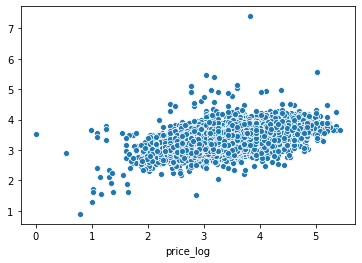

In [976]:
sns.scatterplot(test_y, test_prediction)

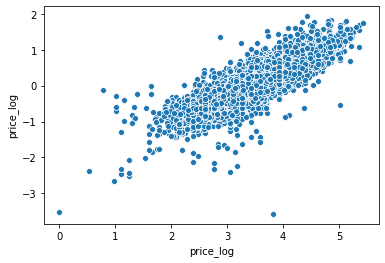

In [977]:
sns.scatterplot(test_y, test_y - test_prediction)

In [700]:
# sns.scatterplot(test_y, np.random.randn(len(test_y)))

In [978]:
# dataset_df.groupby(["neighbourhood_cleansed", "room_type", "accommodates", "bedrooms", "beds", "shared_bath", "baths_number"])["price_value"].agg(["mean", "count"])

In [979]:
import matplotlib.pyplot as plt

(array([ 1.,  1.,  0.,  3.,  6., 30., 30., 21.,  5.,  3.]),
 array([2.42774824, 2.58009778, 2.73244733, 2.88479688, 3.03714643,
        3.18949598, 3.34184553, 3.49419507, 3.64654462, 3.79889417,
        3.95124372]),
 <a list of 10 Patch objects>)

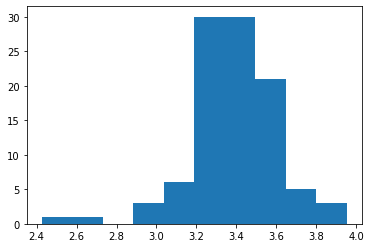

In [980]:
plt.hist(test_y.values[np.argsort(np.abs(test_y - test_prediction))][0:100])

(array([ 3.,  8., 27., 20., 19., 13.,  6.,  2.,  1.,  1.]),
 array([2.23359222, 2.51196098, 2.79032974, 3.06869851, 3.34706727,
        3.62543603, 3.90380479, 4.18217355, 4.46054231, 4.73891108,
        5.01727984]),
 <a list of 10 Patch objects>)

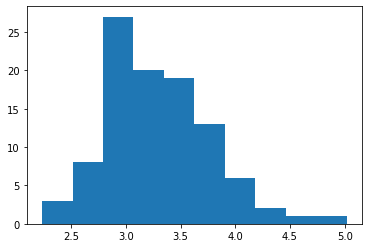

In [981]:
plt.hist(test_y.values[-np.argsort(np.abs(test_y - test_prediction))][0:100])

In [926]:
eli5.explain_weights(search.best_estimator_, feature_names=list(X.columns))

Weight?,Feature
+0.094,bedrooms>1
+0.094,bedrooms<1
+0.094,room_type_Entire home/apt
+0.088,bedrooms=1
+0.084,accommodates=1
+0.065,accommodates=2
+0.059,bathrooms=1
+0.039,bathrooms<1
+0.039,bathrooms>1
+0.009,room_type_Hotel room
